# Inspecting knowledge base of training data

We want to see if the `feature layers` we are using for the ML crop/non-crop mask are actually useful for distinguishing the two classes. We can understand the knowledge base built by the training data in a couple of ways:

1. Plotting class-specific `box plots` for each feature layer.

2. Plot the class-specific `principal components` of each class e.g. PC1 vs PC2 as a scatter-plot


## Load modules

In [1]:
%matplotlib inline

import sys
import os
import xarray as xr
import subprocess as sp
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

sys.path.append('../Scripts')
from deafrica_classificationtools import collect_training_data 

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


## Analysis Parameters

In [2]:
ncpus=int(float(sp.getoutput('env | grep CPU')[-3:]))
path = 'data/training_validation/cropmask_training_polys_test.shp'   
field = 'class'
products =  ['ga_ls8c_gm_2_annual'] #['usgs_ls8c_level2_2']
time = ('2018-01', '2018-12')
custom_func = None #test_custom_func
reduce_func = None #'mean'
calc_indices = ['NDVI', 'NDWI'] 
drop = False
zonal_stats = None #'median' 
resolution =  (-30, 30)
align = (15,15)

print('ncpus = '+str(ncpus))

ncpus = 2


## Collect training data

In [3]:
#open shapefile and ensure its in WGS84 coordinates
input_data = gpd.read_file(path).to_crs('epsg:4326')

#check the shapefile by plotting it
# map_shapefile(input_data, attribute=field)

In [7]:
# a datacube query object
query = {
    'time': time,
    'measurements': ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'],
    'resolution': resolution,
    'align' : align,
    'group_by' :'solar_day',
}


In [8]:
column_names, model_input = collect_training_data(ncpus=ncpus,
                                    gdf=input_data,
                                    products=products,
                                    dc_query=query,
                                    custom_func=custom_func,
                                    field=field,
                                    calc_indices=calc_indices,
                                    reduce_func=reduce_func,
                                    drop=drop,
                                    zonal_stats=zonal_stats)

print(column_names)

Calculating indices: ['NDVI', 'NDWI']


100%|██████████| 253/253 [02:35<00:00,  1.63it/s]



Output training data has shape (1537795, 9)
Removed NaNs, cleaned input shape:  (1537795, 9)
['class', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'NDVI', 'NDWI']


## Data Wrangling

**Seperate crop and non-crop classes**

In [9]:
crop = model_input[model_input[:,0]==1]
non_crop = model_input[model_input[:,0]==2]

**Convert into pandas dataframes for ease**

In [10]:
crop_df = pd.DataFrame(crop).rename(columns={i:column_names[i] for i in range(0,len(column_names))}).drop('class', axis=1)
non_crop_df = pd.DataFrame(non_crop).rename(columns={i:column_names[i] for i in range(0,len(column_names))}).drop('class', axis=1)

**Normalise values**

So they can all plot on the same graph. Normalize by maximum values

In [11]:
# standardise the SR columns to 0-1
SR_max_value = 65455

for i in column_names[1:7]:
    crop_df[i] = crop_df[i] / SR_max_value
    
for i in column_names[1:7]:
    non_crop_df[i] = non_crop_df[i] / SR_max_value
    
#standardise NDWI to 0-1
crop_df['NDWI'] = crop_df['NDWI'] / -1
non_crop_df['NDWI'] = non_crop_df['NDWI'] / -1

---
## Feature layer boxplots

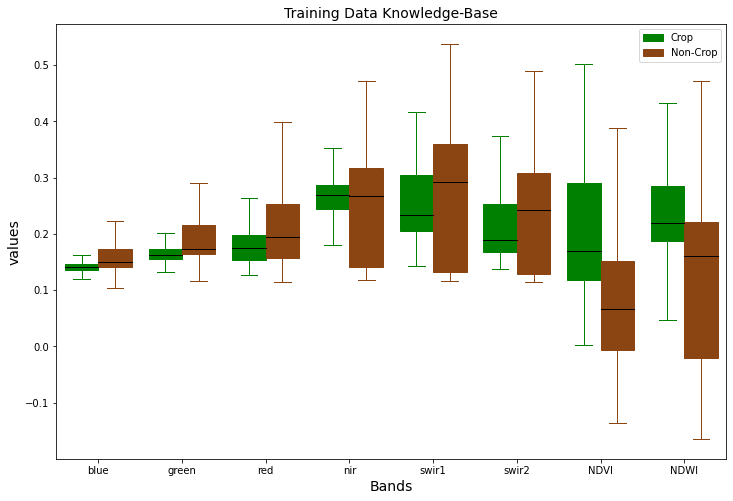

In [12]:
fig, ax = plt.subplots(figsize=(12,8))

crop_col ='green'
non_crop_col ='saddlebrown'

pp = ax.boxplot(crop_df.values,
                patch_artist=True,
                showfliers=False, 
                positions=np.arange(crop_df.values.shape[1])-.2, widths=0.4,
                boxprops=dict(facecolor=crop_col, color=crop_col),
                capprops=dict(color=crop_col),
                whiskerprops=dict(color=crop_col),
                flierprops=dict(color=crop_col, markeredgecolor=crop_col),
                medianprops=dict(color='black'))   

fp = ax.boxplot(non_crop_df.values,
                patch_artist=True, 
                showfliers=False,
                positions=np.arange(crop_df.values.shape[1])+.2, widths=0.4,
                boxprops=dict(facecolor=non_crop_col, color=non_crop_col),
                capprops=dict(color=non_crop_col),
                whiskerprops=dict(color=non_crop_col),
                flierprops=dict(color=non_crop_col, markeredgecolor=non_crop_col),
                medianprops=dict(color='black'))   

ax.set_xticks(np.arange(len(column_names[1:])))
ax.set_xticklabels(column_names[1:])
ax.set_xlim(-0.5,len(column_names[1:])-.5)
ax.set_ylabel("values", fontsize=14)
ax.set_xlabel("Bands", fontsize=14)
ax.set_title("Training Data Knowledge-Base", fontsize=14)
ax.legend([pp["boxes"][0], fp["boxes"][0]], ['Crop', 'Non-Crop'], loc='upper right')

plt.show()

---
## Principal Component Analysis

Conduct the PCA on the two classes

First we should standardize the values before conducting the PCA.
Couple of ways to do this, using `StandardScaler` for now i.e. `x-u/s`

In [13]:
# Standardizing the features
crop_std = StandardScaler().fit_transform(crop)
non_crop_std = StandardScaler().fit_transform(non_crop)

In [14]:
pca = PCA(n_components=2)

crop_pca = pca.fit_transform(crop_std)
non_crop_pca = pca.fit_transform(non_crop_std)

Place back into pandas dataframes

In [15]:
crop_pca = pd.DataFrame(crop_pca, columns = ['PC1', 'PC2'])
crop_pca['class']='crop'

non_crop_pca = pd.DataFrame(non_crop_pca, columns = ['PC1', 'PC2'])
non_crop_pca['class']='non-crop'

df = pd.concat([crop_pca, non_crop_pca])

### Plot the principal components

Only plot a random subsample of the dataset as its huge

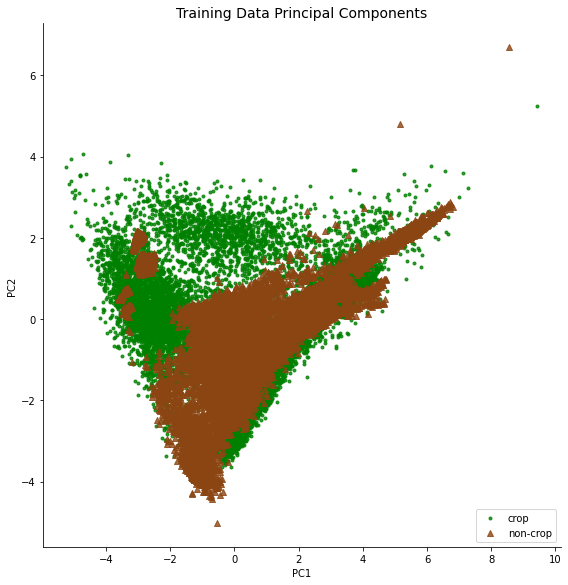

In [19]:
num_of_points = 40000

sns.lmplot(x="PC1", y="PC2",
           data=df.sample(n=num_of_points),
           fit_reg=False,
           hue='class',
           legend=False,
           size=8,
           markers=[".", "^"],
           palette=['green', 'saddlebrown'])

plt.legend(loc='lower right')
plt.title('Training Data Principal Components', fontsize=14)
plt.show()